Advanced Lane Finding Using Computer Vision Techniques
----------------------------------------------------------

### Key Steps
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
1. Apply a distortion correction to raw images.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [41]:
# Import Libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib qt
%matplotlib inline

### 1. Camera Calibration

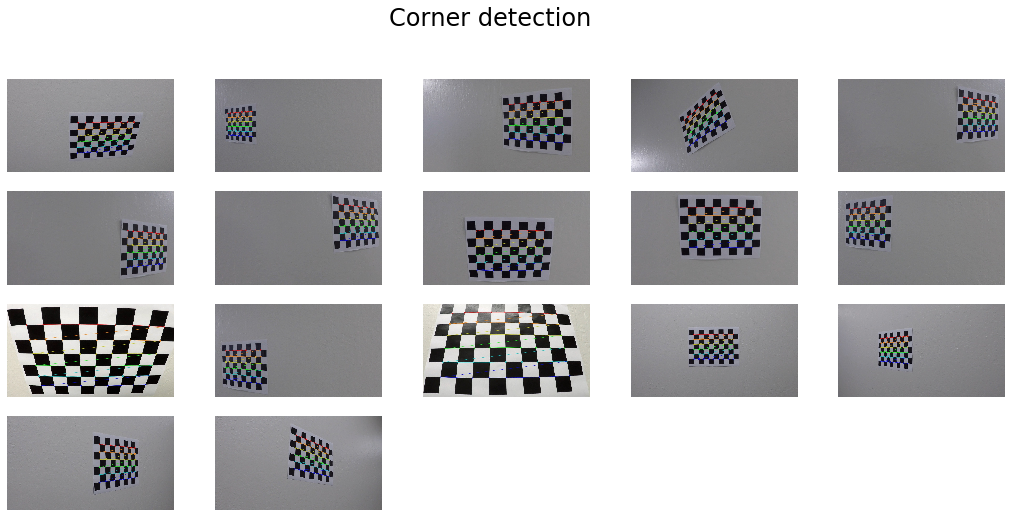

In [249]:
# Object points - 6X9 grid, x,y,z coordinates
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
flag = True
corners_detected = []
corners_undetected = []
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = np.copy(img)
    # Find chessboard corners, no thresholding
    ret, corners = cv2.findChessboardCorners(img, (9,6), None)
    
    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(dst, (9,6), corners, ret)
        write_name = 'camera_cal/corners_found/'+os.path.splitext(os.path.basename(fname))[0]+'_corners_found'+'.jpg'
        corners_detected.append(write_name)
        cv2.imwrite(write_name, dst)
    else:
        corners_undetected.append(fname)

plt.figure(figsize=(18, 10))
plt.suptitle("Corner detection", size=24)
for i, image in enumerate(corners_detected):
    img = cv2.imread(image)
    plt.subplot2grid((5,5), (i//5, i%5), colspan=1, rowspan=1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

### 2. Distortion Correction

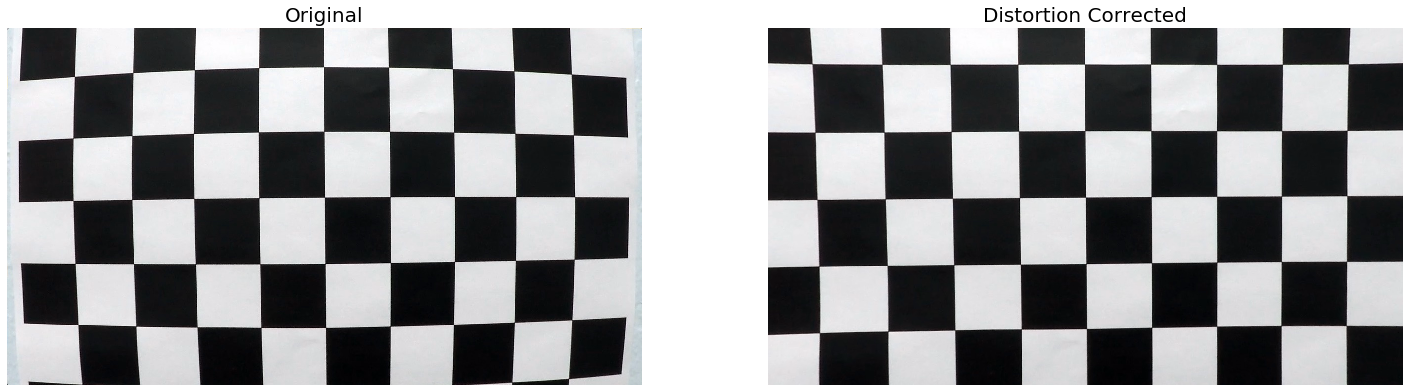

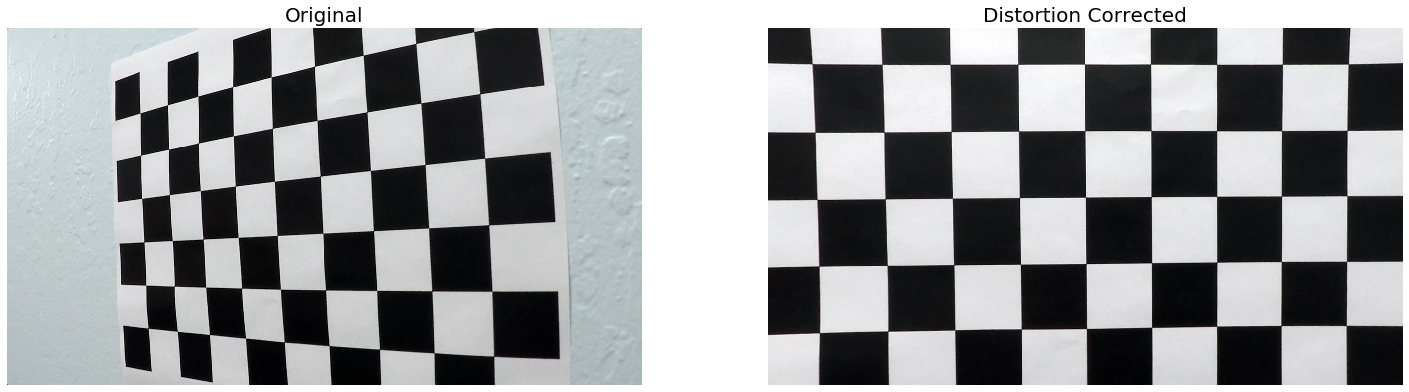

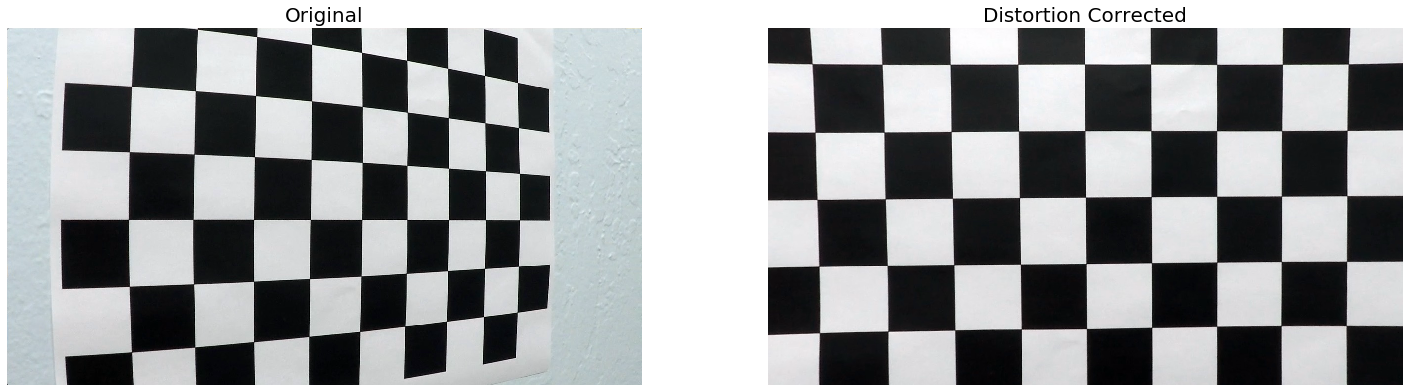

In [270]:
def distortion_corr(img):
    test_img_size = (test_img.shape[1], test_img.shape[0])
    # Perform camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img_size, None, None)
    dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    #cv2.imwrite('camera_cal/distortion_test_undistorted.jpg', dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
    
    return dst

for i, image in enumerate(corners_undetected):
    f, (x1, x2) = plt.subplots(1, 2, figsize=(25, 10))
    x1.axis('off')
    img = cv2.imread(image)
    x1.imshow(img)
    x1.set_title('Original', fontsize=20)
    x2.axis('off')
    x2.imshow(distortion_corr(img))
    x2.set_title('Distortion Corrected', fontsize=20) 

### 3a. Color Thresholding

In [219]:
def color_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return color_binary

### 3b. Gradient Thresholding

In [220]:
def grad_threshold(c_binary):
    sobel_kernel = 9
    thresh_min = 90
    thresh_max = 255
    sobelx = cv2.Sobel(c_binary, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(c_binary, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_mag_binary = np.zeros_like(scaled_sobel)
    grad_mag_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return grad_mag_binary

### 3c. Combined Thresholding

In [221]:
def combined_threshold(color_binary, grad_binary):
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(grad_binary == 1) | (color_binary == 1)] = 1
    stack_color = np.dstack(( np.zeros_like(color_binary), color_binary, grad_binary)) * 255
    return stack_color, combined_binary

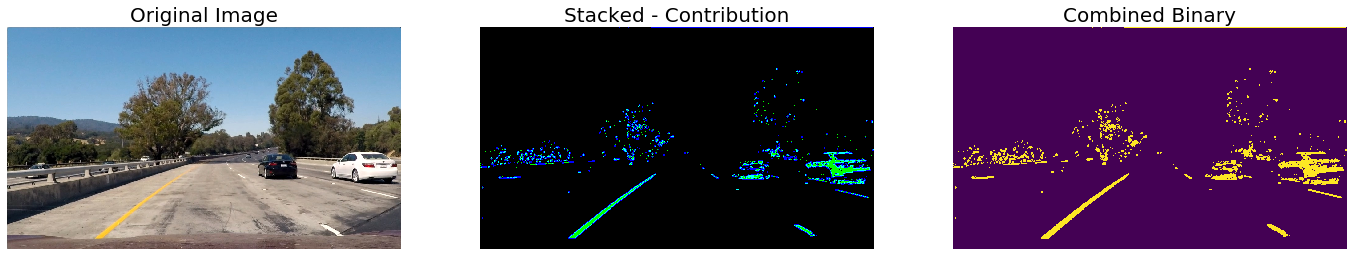

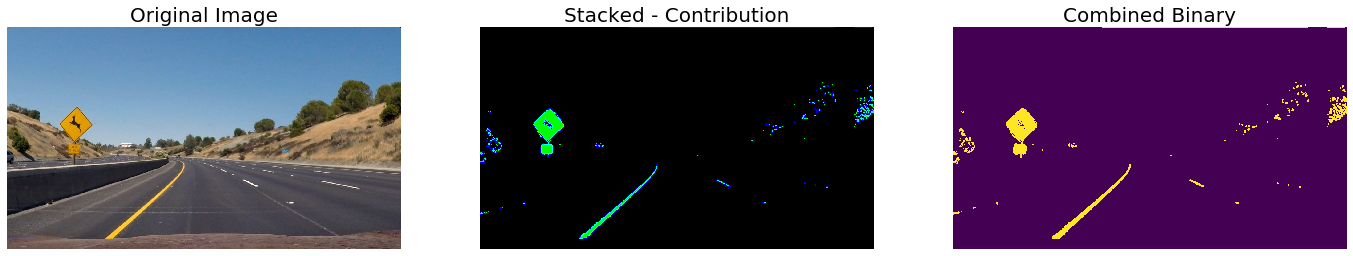

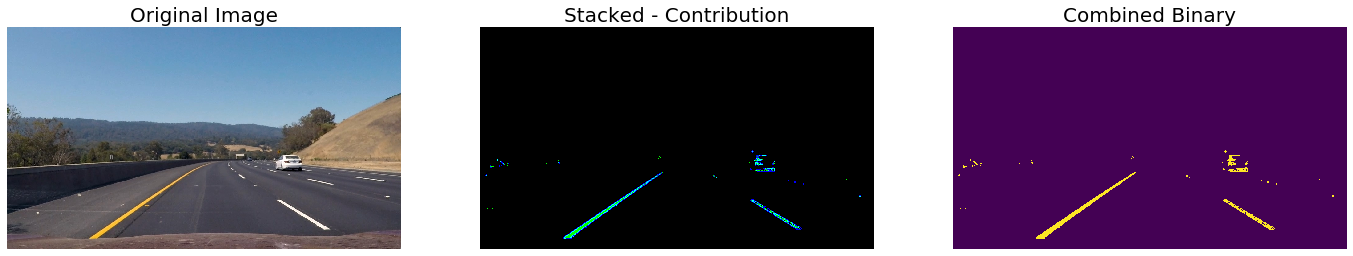

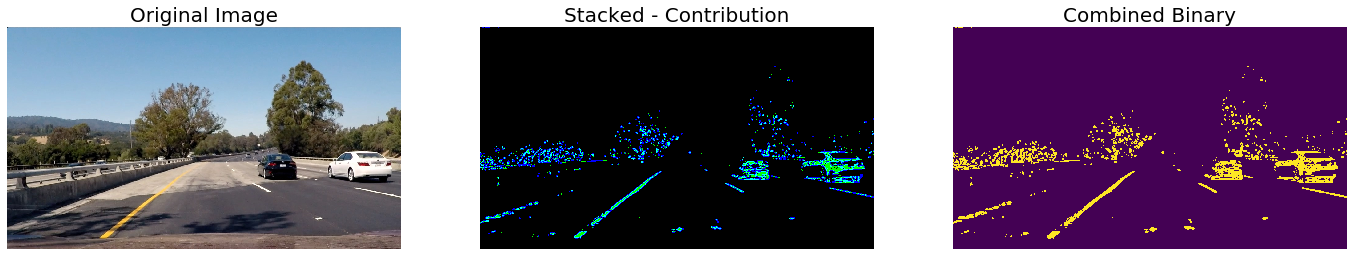

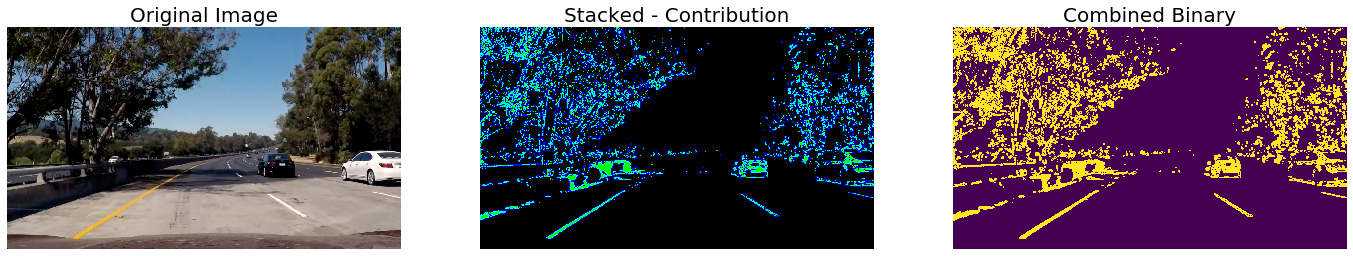

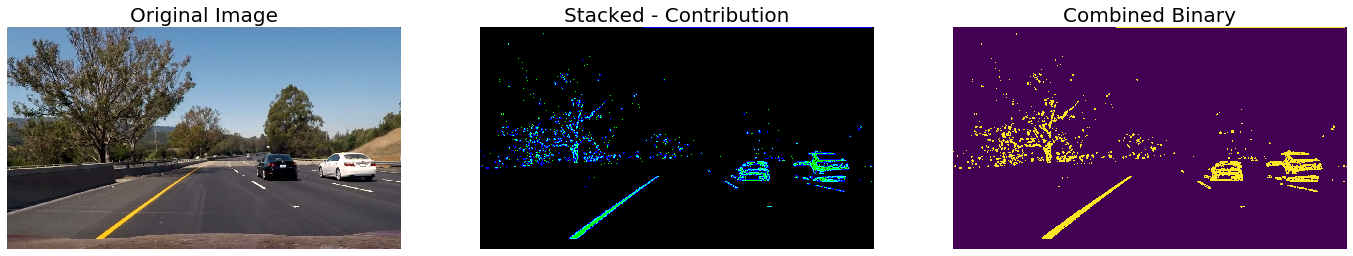

In [224]:
for file in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_binary = color_threshold(img)
    grad_binary = grad_threshold(color_binary)
    stack_color, combined_binary =  combined_threshold(color_binary, grad_binary)
    f, (x1, x2, x3) = plt.subplots(1, 3, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(img)
    x1.set_title('Original Image', fontsize=20)

    x2.axis('off')
    x2.imshow(stack_color)
    x2.set_title('Stacked - Contribution', fontsize=20)
    
    x3.axis('off')
    x3.imshow(combined_binary)
    x3.set_title('Combined Binary', fontsize=20)

### Perspective Transform

In [335]:
def perspective_transform(image):
    ht = image.shape[0]
    wt = image.shape[1]
    
    # source points
    src1 = [wt // 2 - 70, ht * 0.625]
    src2 = [wt // 2 + 70, ht * 0.625]
    src3 = [-100, ht]
    src4 = [wt + 100, ht]
    src = np.float32([src1, src2, src3, src4])
    poly = np.array((src1, src2, src4, src3), np.int32) 
    cv2.polylines(image, [poly], True, (0,0, 255), 5)
    
    # destination points
    dst1 = [100, 0]
    dst2 = [wt - 100, 0]
    dst3 = [100, ht]
    dst4 = [wt - 100, ht]
    dst = np.float32([dst1, dst2, dst3, dst4])
    
    # perspective transform matrix and warping
    M = cv2.getPerspectiveTransform(src, dst)
    unwarped = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, (wt, ht))
    return warped

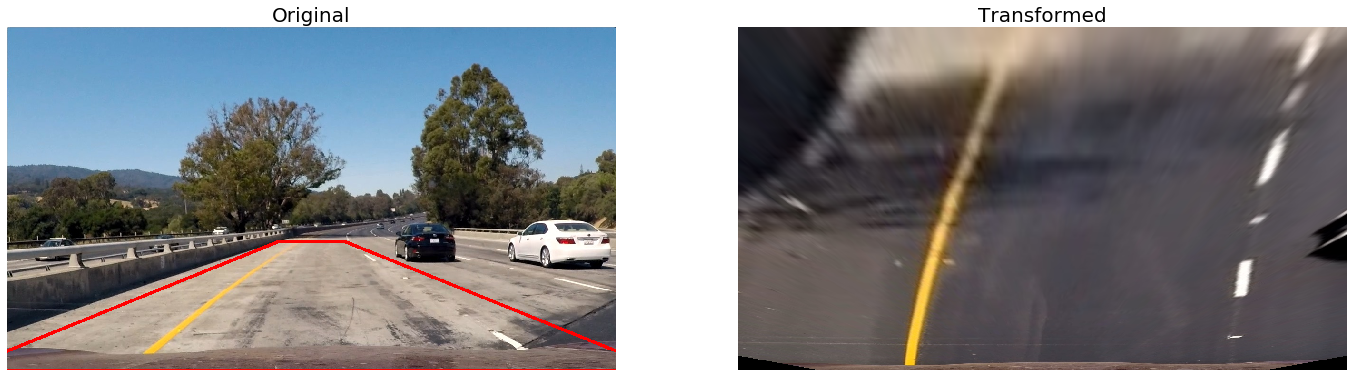

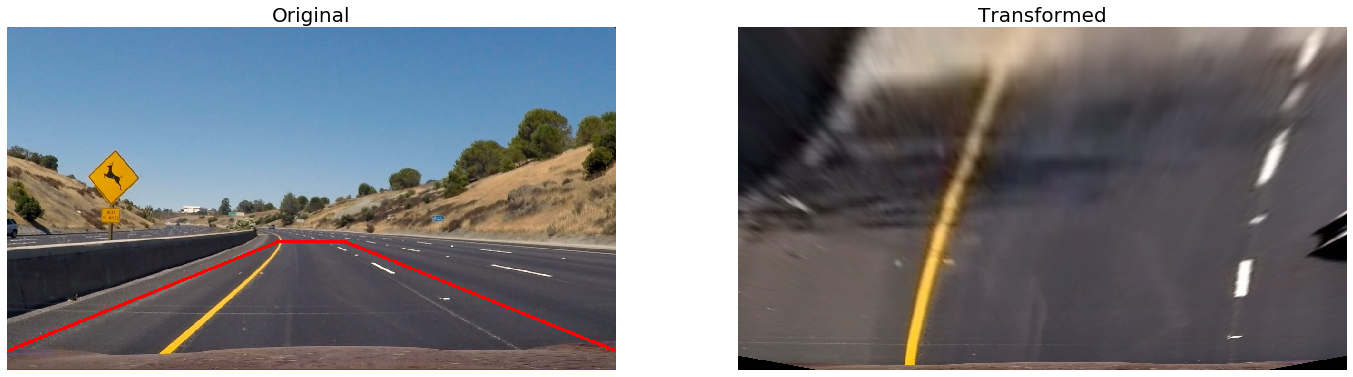

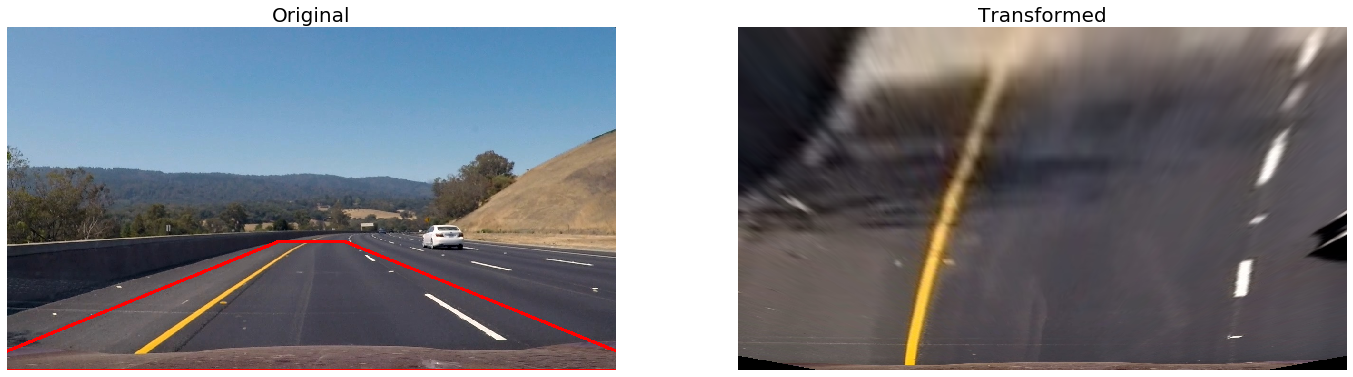

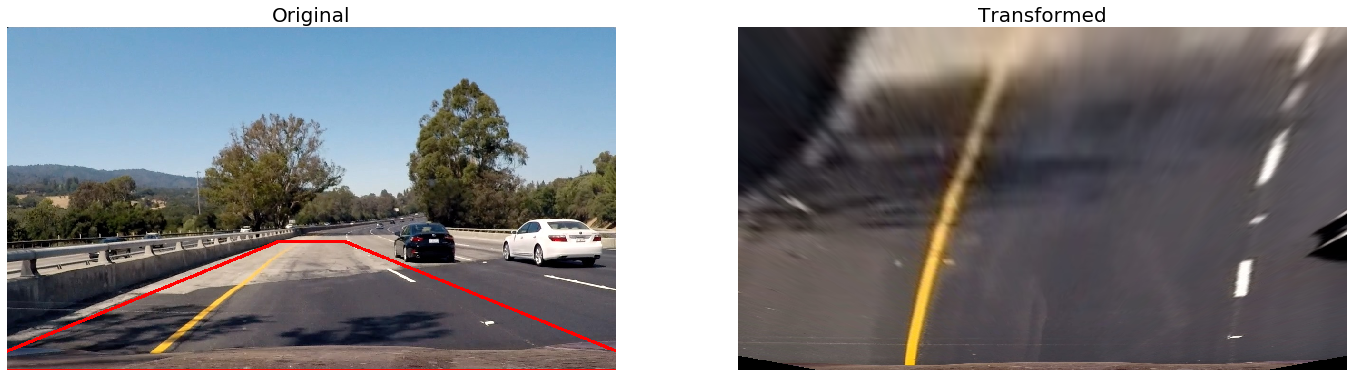

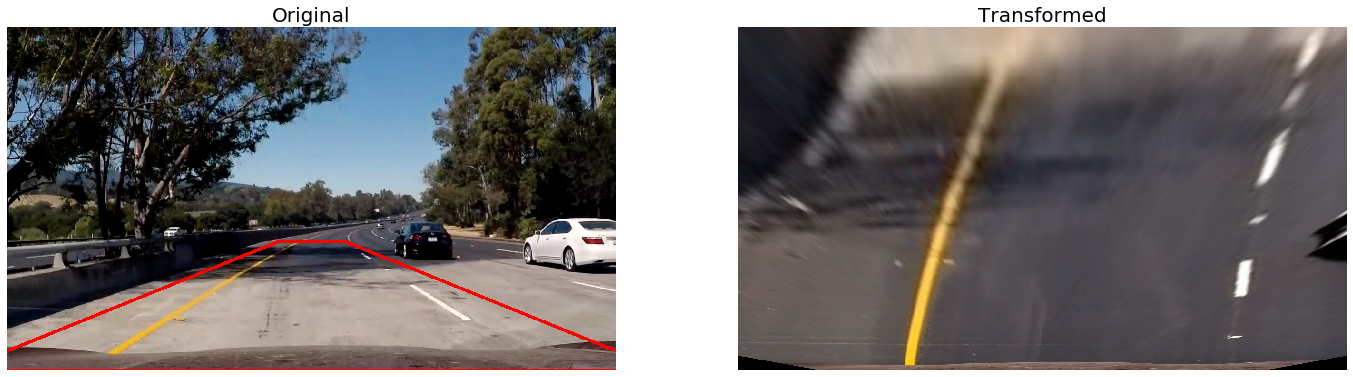

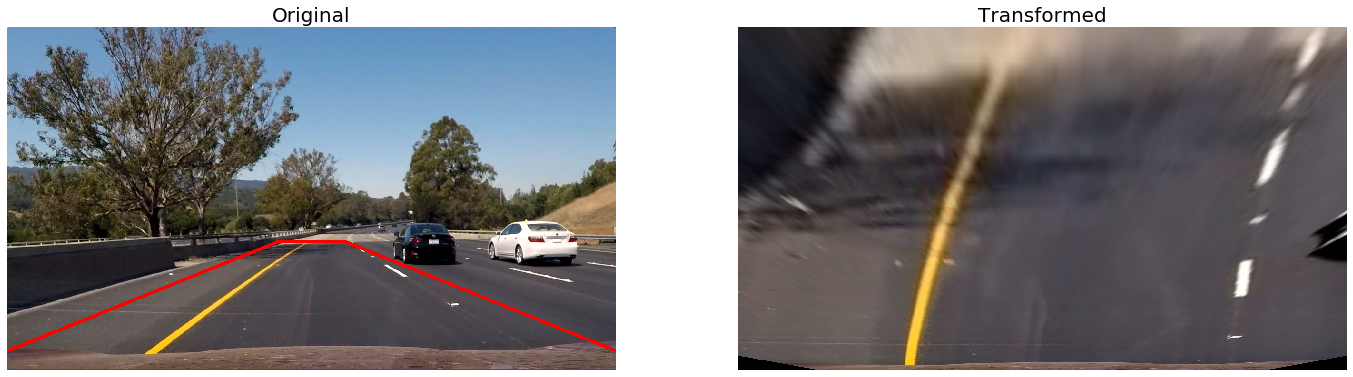

In [336]:
for image in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image)
    warped = perspective_transform(image) 
    
    f , (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))
    x2.set_title('Transformed', fontsize=20)

### 5. Detect lane pixels and fit a polynomial